## Importing Libraries

In [2]:
import gym
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.models import load_model
from keras.utils import plot_model
from collections import deque

import matplotlib.pyplot as plt
import random

Using TensorFlow backend.


## Creating the environment

In [3]:
env = gym.make('LunarLander-v2')

## Random Actions taken by Lander

In [4]:
for i in range(5):
    state = env.reset()
    done = False
    for time in range(100):
        while done == False:
            env.render()
            action = env.action_space.sample()
            next_state, reward, done, _ = env.step(action)
env.close()        

## Initializing Parameters

In [27]:
learning_rate = 0.001
replay_buffer  = deque(maxlen=int(1e5))
gamma = 0.99
tau = 1e-3
eps_decay = 0.995
batch_size = 64
target_update_step = 4

## Defining Keras Model

In [28]:
def initialize_training_model(env, learning_rate):
    input_shape = env.observation_space.shape[0]
    output_shape = env.action_space.n
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_shape))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_shape))
    model.compile(optimizer=Adam(lr=learning_rate),loss="mean_squared_error")
    return model

## Initializing Prediction and Target Models

In [29]:
train_model = initialize_training_model(env,learning_rate)
target_model = initialize_training_model(env,learning_rate)

## Function for choosing Actions

In [30]:
def choose_action(env,train_model,epsilon,state):
    if np.random.random() < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(train_model.predict(state)[0])
    return action

## Function to train target network

In [31]:
def train_target_network(train_model, target_model, tau):
    training_weights = train_model.get_weights()
    target_weights = target_model.get_weights()
    for i in range(len(target_weights)):
        target_weights[i] = tau*training_weights[i] + (1-tau)*target_weights[i]
    target_model.set_weights(target_weights)
    return target_model

## Training Function

In [32]:
def train(env,learning_rate, gamma, tau, batch_size, target_update_step, eps_decay,train_model,target_model,num_episodes,time_steps):
    eps = 1.0
    eps_min = 0.01
    
    reward_buffer = []
    epsilon_buffer = []
    replay_buffer = deque(maxlen=int(1e5))
    reward_buffer_100 = deque(maxlen=100)
    for episode in range(num_episodes):
        epsilon_buffer.append(eps)
        current_state = env.reset()
        cum_reward = 0
        current_state = current_state.reshape((1,len(current_state)))
        for t in range(time_steps):
            action = choose_action(env,train_model,eps,current_state)
            new_state, reward, done, _ = env.step(action)
            new_state = new_state.reshape((1,len(new_state)))
            cum_reward += reward
            replay_buffer.append([current_state, action, reward, new_state, done])
            if len(replay_buffer) > batch_size:
                if (t+1)%target_update_step == 0:
                
                    y_vector = []
                    states = []
                    samples = random.sample(replay_buffer,batch_size)
                    for state_d, action_d, reward_d, new_state_d, done_d in samples:
                        if done_d:
                            y = reward_d
                        else:
                            new_q = np.amax(target_model.predict(new_state_d)[0])
                            y = reward_d + gamma * new_q
                        q = train_model.predict(state_d)
                        q[0][action_d] = y
                        y_vector.append(q[0])
                        states.append(state_d[0])
                    train_model.fit(np.array(states), np.array(y_vector), epochs=1, verbose=0)
                    target_model = train_target_network(train_model, target_model, tau)
            current_state = new_state
            if done:
                break
        reward_buffer.append(cum_reward)
        reward_buffer_100.append(cum_reward)
        eps = eps*eps_decay
        eps = max(eps_min,eps)
        print("\repisode " + str(episode) + "\ttotalreward " + str(np.mean(reward_buffer_100)),end="\r")
        if episode % 100 == 0:
            print("\repisode " + str(episode) + "\ttotalreward " + str(np.mean(reward_buffer_100)))
            
        if np.mean(reward_buffer_100)>=200.0:
            train_model.save("dqn_model_lr_001.h5")
            print("achieved mean score value")
            break
    env.close()
    return(reward_buffer,epsilon_buffer)

In [33]:
num_episodes = 2000
time_steps = 1000
train_scores, epsilons = train(env,learning_rate, gamma, tau, batch_size, target_update_step, eps_decay,train_model,target_model,num_episodes,time_steps)

episode 0	totalreward -107.80347203535906
episode 100	totalreward -138.25869878399496
episode 200	totalreward -80.296993608853352
episode 300	totalreward -64.09950808774579
episode 400	totalreward 44.2882497881903664
episode 500	totalreward 123.66350888661157
episode 600	totalreward 166.03014889938902
episode 700	totalreward 178.19598914497956
achieved mean score value01.06990825934588


## Generate Figure 1 of report

W0630 22:30:14.560961 140328144553792 legend.py:1289] No handles with labels found to put in legend.


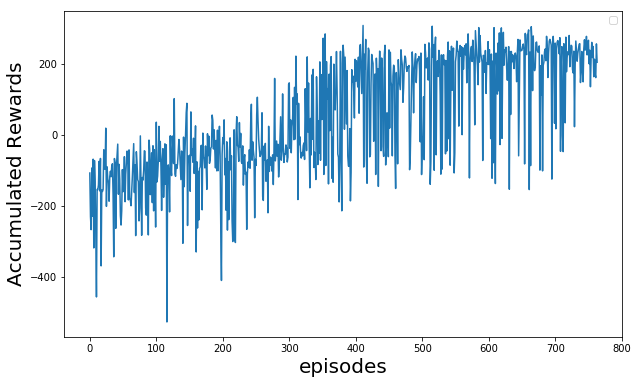

In [36]:
plt.figure(figsize=(10,6))
fig1 = plt.gcf()
x_values = np.arange(len(train_scores))
plt.plot(x_values, train_scores)
plt.ylabel('Accumulated Rewards',size=20)
plt.xlabel('episodes',size=20)
plt.legend()
plt.show()
fig1.savefig('training_vs_episodes.png',dpi=100)

## Model Summary

In [37]:
savedmodel = load_model("dqn_model_trained.h5")

In [38]:
savedmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             (None, 64)                576       
_________________________________________________________________
dense_74 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_75 (Dense)             (None, 4)                 260       
Total params: 4,996
Trainable params: 4,996
Non-trainable params: 0
_________________________________________________________________


## Testing the model

In [39]:
def test(env,model):
    state = env.reset()
    score_vector = []
    
    for i in range(100):
        state = env.reset()
        state = state.reshape((1,len(state)))
        done = False
        cum_reward = 0
        for time in range(100):
            while done == False:
                env.render()
                action = np.argmax(model.predict(state)[0])
                next_state, reward, done, _ = env.step(action)
                next_state = next_state.reshape((1,len(next_state)))
                state = next_state
                cum_reward += reward 
        score_vector.append(cum_reward)
        print("episode = " + str(i) + "\ttotal_rewards = " + str(cum_reward))
    env.close()
    return score_vector

## Generating Test Scores

In [40]:
test_scores = test(env,savedmodel)

## Generate Figure 2 of report

W0630 23:09:51.269138 140328144553792 legend.py:1289] No handles with labels found to put in legend.


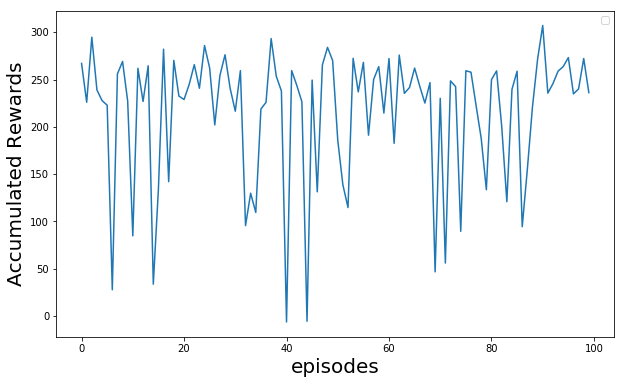

In [41]:
plt.figure(figsize=(10,6))
fig1 = plt.gcf()
x_values = np.arange(len(test_scores))
plt.plot(x_values, test_scores)
plt.ylabel('Accumulated Rewards',size=20)
plt.xlabel('episodes',size=20)
plt.legend()
plt.show()
fig1.savefig('test-scores_vs_episodes.png',dpi=100)

## Mean Score on Test Dataset for 100 episodes

In [43]:
np.mean(test_scores)

215.8435094089972

## Training using different Learning rates

In [65]:
learning_rates = {"0.1" : [], "0.01" : [], "0.001" : [], "0.0001" : [], "0.00001" : []}

In [66]:
replay_buffer  = deque(maxlen=int(1e5))

for l_rate in learning_rates.keys():
    num_episodes = 1000
    time_steps = 500
    replay_buffer  = deque(maxlen=int(1e5))
    gamma = 0.99
    tau = 1e-3
    eps_decay = 0.995
    batch_size = 64
    target_update_step = 4
    print("Training for Learning rate = " + str(l_rate))
    train_model = initialize_training_model(env,np.float32(l_rate))
    target_model = initialize_training_model(env,np.float32(l_rate))
    train_scores, epsilons = train(env,np.float32(l_rate), gamma, tau, batch_size, target_update_step, eps_decay,train_model,target_model,num_episodes,time_steps)
    learning_rates[l_rate] = train_scores

Training for Learning rate = 0.1
episode 0	 Mean Score: -357.733 	 with epsilon: 0.995
episode 100	 Mean Score: -242.812 	 with epsilon: 0.603
episode 200	 Mean Score: -264.449 	 with epsilon: 0.365
episode 300	 Mean Score: -286.171 	 with epsilon: 0.221
episode 400	 Mean Score: -281.155 	 with epsilon: 0.134
episode 500	 Mean Score: -317.649 	 with epsilon: 0.081
episode 600	 Mean Score: -314.055 	 with epsilon: 0.049
episode 700	 Mean Score: -311.871 	 with epsilon: 0.030
episode 800	 Mean Score: -266.261 	 with epsilon: 0.018
episode 900	 Mean Score: -290.244 	 with epsilon: 0.011
episode 999	 Mean Score: -257.170 	 with epsilon: 0.010Training for Learning rate = 0.01
episode 0	 Mean Score: -227.562 	 with epsilon: 0.995
episode 100	 Mean Score: -131.217 	 with epsilon: 0.603
episode 200	 Mean Score: -78.601 	 with epsilon: 0.3653
episode 300	 Mean Score: -2.654 	 with epsilon: 0.2217
episode 400	 Mean Score: 34.064 	 with epsilon: 0.134
episode 500	 Mean Score: 27.535 	 with epsilo

## Generating Figure 3 of Report

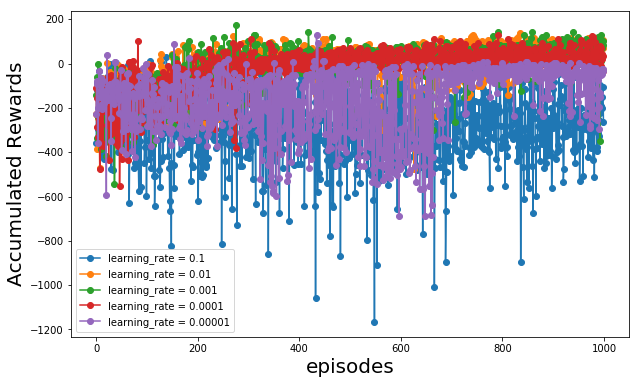

In [74]:
plt.figure(figsize=(10,6))
fig1 = plt.gcf()
x_values = np.arange(len(train_scores))
for l_rate in learning_rates.keys():
    plt.plot(x_values,learning_rates[l_rate],'-o',label='learning_rate = {}'.format(l_rate))
plt.ylabel('Accumulated Rewards',size=20)
plt.xlabel('episodes',size=20)

plt.legend()
plt.show()
fig1.savefig('learning_rate1.png',dpi=100)

## Training with different Gammas'

In [12]:
gamma_vector = {"0.6" : [], "0.7" : [], "0.8" : [], "0.9" : [], "0.99" : []}
#gamma_vector = {"0.99" : []}

In [13]:
for gamma in gamma_vector.keys():
    num_episodes = 700
    time_steps = 500
    replay_buffer  = deque(maxlen=int(1e5))
    l_rate = 0.001
    tau = 1e-3
    eps_decay = 0.995
    batch_size = 64
    target_update_step = 4
    print("Training for Gamma = " + str(gamma))
    train_model = initialize_training_model(env,np.float32(l_rate))
    target_model = initialize_training_model(env,np.float32(l_rate))
    train_scores, epsilons = train(env,l_rate, np.float32(gamma), tau, batch_size, target_update_step, eps_decay,train_model,target_model,num_episodes,time_steps)
    gamma_vector[gamma] = train_scores

Training for Gamma = 0.6


W0630 14:17:25.995040 140328144553792 deprecation_wrapper.py:119] From /home/sudeep/anaconda3/lib/python3.7/site-packages/Keras-2.2.4-py3.7.egg/keras/backend/tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0630 14:17:26.067106 140328144553792 deprecation_wrapper.py:119] From /home/sudeep/anaconda3/lib/python3.7/site-packages/Keras-2.2.4-py3.7.egg/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



episode 0	totalreward -261.56841805459396
episode 100	totalreward -165.3868141759531
episode 200	totalreward -107.30021548393114
episode 300	totalreward -79.127023939220693
episode 400	totalreward -71.76830100933132
episode 500	totalreward -62.550238371678205
episode 600	totalreward -65.184109146585715
Training for Gamma = 0.7-64.352764692906084
episode 0	totalreward -190.2548898716577
episode 100	totalreward -145.28216053202593
episode 200	totalreward -105.76252185559468
episode 300	totalreward -46.549247642651224
episode 400	totalreward -55.256969841779714
episode 500	totalreward -56.263197486897376
episode 600	totalreward -36.027183614115224
Training for Gamma = 0.8-48.024809118692054
episode 0	totalreward -213.0883667851216
episode 100	totalreward -138.26627155658005
episode 200	totalreward -78.530106391594137
episode 300	totalreward -41.462011858157725
episode 400	totalreward -20.049295767926118
episode 500	totalreward -10.555153665842024
episode 600	totalreward -10.19663610076747

## Generating Figure 4 of Report

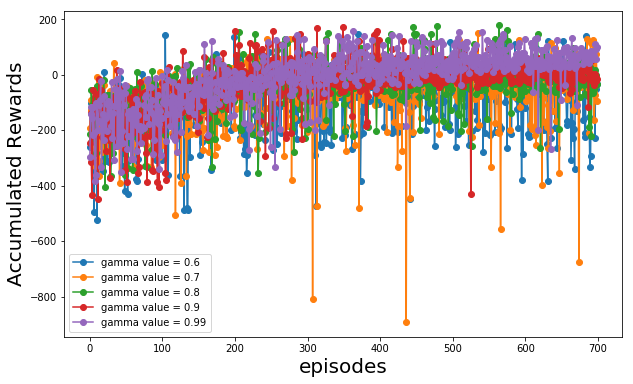

In [24]:
plt.figure(figsize=(10,6))
fig1 = plt.gcf()
x_values = np.arange(len(train_scores))
for gamma in gamma_vector.keys():
    plt.plot(x_values,gamma_vector[gamma],'-o',label='gamma value = {}'.format(gamma))
plt.ylabel('Accumulated Rewards',size=20)
plt.xlabel('episodes',size=20)

plt.legend()
plt.show()
fig1.savefig('gamma_train.png',dpi=100)

In [19]:
eps_decay_vector = {"0.8" : [], "0.9" : [], "0.995" : [], "1" : []}

In [21]:
for decay in eps_decay_vector.keys():
    num_episodes = 700
    time_steps = 500
    replay_buffer  = deque(maxlen=int(1e5))
    l_rate = 0.001
    tau = 1e-3
    batch_size = 64
    target_update_step = 4
    gamma = 0.99
    print("Training for decay = " + str(decay))
    train_model = initialize_training_model(env,np.float32(l_rate))
    target_model = initialize_training_model(env,np.float32(l_rate))
    train_scores, epsilons = train(env,l_rate, np.float32(gamma), tau, batch_size, target_update_step, np.float32(decay),train_model,target_model,num_episodes,time_steps)
    eps_decay_vector[decay] = train_scores

Training for decay = 0.8
episode 0	totalreward -83.52869052718793
episode 100	totalreward -239.92039876130556
episode 200	totalreward -68.778440745515482
episode 300	totalreward -70.101809439405055
episode 400	totalreward -45.809251450517515
episode 500	totalreward -7.3639369027395636
episode 600	totalreward -18.441718692127826
Training for decay = 0.95.059906128097837567
episode 0	totalreward -119.7645006670257
episode 100	totalreward -188.30840066368313
episode 200	totalreward -18.582959764384126
episode 300	totalreward -44.848526495654035
episode 400	totalreward -62.303895921001024
episode 500	totalreward -45.364498256083124
episode 600	totalreward -16.420309667764553
Training for decay = 0.995.62836751409053198
episode 0	totalreward -120.1300096880521
episode 100	totalreward -141.58039475816594
episode 200	totalreward -88.356868228239957
episode 300	totalreward -8.6233647955194295
episode 400	totalreward 5.16944909014377868
episode 500	totalreward 48.994517764580076
episode 600	tot

## Generating Figure 5 of Report

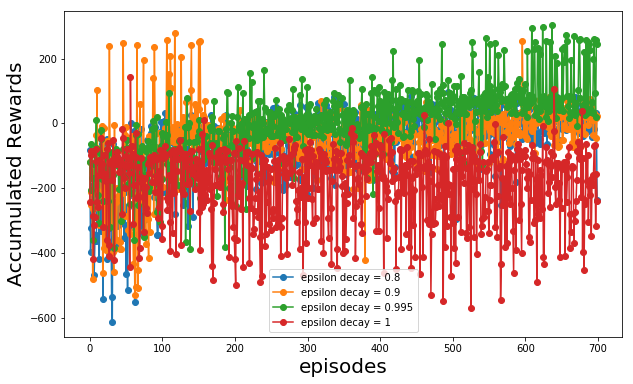

In [23]:
plt.figure(figsize=(10,6))
fig1 = plt.gcf()
x_values = np.arange(len(train_scores))
for eps in eps_decay_vector.keys():
    plt.plot(x_values,eps_decay_vector[eps],'-o',label='epsilon decay = {}'.format(eps))
plt.ylabel('Accumulated Rewards',size=20)
plt.xlabel('episodes',size=20)

plt.legend()
plt.show()
fig1.savefig('eps_train.png',dpi=100)

## END